In [ ]:
pip install pgmpy

In [42]:
import os
os.getcwd()


'c:\\Users\\Antonio Luque\\Desktop\\Carpetas\\UIT\\INF-2600 AI\\Assignment 3'

In [ ]:
pip install seaborn

In [43]:
# Including the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Factoring the dataset

In [44]:
# Import data, make a copy of the original

df0 = pd.read_csv('./seattle-weather.csv')
dfc1 = df0.copy()
dfc1.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [45]:
# Get characteristics of dataset including columns with missing data as well:
dfc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [46]:
# Checking the unique values in the 'weather' column
unique_fields = dfc1['weather'].unique()
print(unique_fields)

['drizzle' 'rain' 'sun' 'snow' 'fog']


In [47]:
dfc1.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [48]:
# Put categorical varaibles in a list
categorical_lst = ['date','weather']
# Create a seperate & smaller dataframe for categorical variables
dfc2a = pd.DataFrame(dfc1, columns=categorical_lst, copy=True)
dfc2a.head()

,date,weather
0,2012-01-01,drizzle
1,2012-01-02,rain
2,2012-01-03,rain
3,2012-01-04,rain
4,2012-01-05,rain


In [49]:
# Put all continuous variables into a list
continuous_lst = ['precipitation', 'temp_max', 'temp_min', 'wind']
# Create a seperate & smaller dataframe for our chosen variables. Use 'copy=True' so changes wont affect original
dfc2b = pd.DataFrame(dfc1, columns=continuous_lst, copy=True)
dfc2b.head()

,precipitation,temp_max,temp_min,wind
0,0.0,12.8,5.0,4.7
1,10.9,10.6,2.8,4.5
2,0.8,11.7,7.2,2.3
3,20.3,12.2,5.6,4.7
4,1.3,8.9,2.8,6.1


### Create new dataframe

In [50]:
# Create new df with variables we want to work with:
new_cols = ['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather']

df = df0[new_cols]
# df.head()

In [51]:
# Let's show all columns with missing data as well:
df[df.isnull().any(axis=1)] # any missing data in columns
df.isnull().any()

date             False
precipitation    False
temp_max         False
temp_min         False
wind             False
weather          False
dtype: bool

In [52]:
num_stdv = 1

# Define the labels dictionary
labels = {
    'precipitation': ['low', 'mid', 'high'],
    'temp_max': ['low', 'mid', 'high'],
    'temp_min': ['low', 'mid', 'high'],
    'wind': ['low', 'mid', 'high']
}

# Create bounds for continuous labels
for col in df.columns:
    if col in labels:
        col_mean = df[col].mean()
        col_stdv = df[col].std()
        lower_bound = col_mean - col_stdv * num_stdv
        upper_bound = col_mean + col_stdv * num_stdv
        bins = [-float('inf'), lower_bound, upper_bound, float('inf')]
        df[col] = pd.cut(df[col], bins=bins, labels=labels[col])

df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,mid,mid,mid,high,drizzle
1,2012-01-02,high,mid,low,mid,rain
2,2012-01-03,mid,mid,mid,mid,rain
3,2012-01-04,high,mid,mid,high,rain
4,2012-01-05,mid,low,low,high,rain


# Creating Bayes Nets

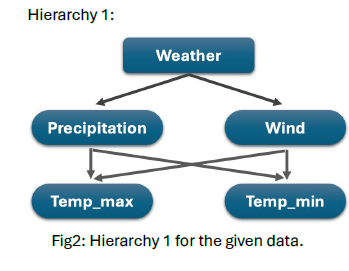

## Hierarchy 1:

In [53]:
# Define the hierarchy
modelfig2 = BayesianNetwork([
    ('weather', 'precipitation'), ('weather', 'wind'),
    ('precipitation', 'temp_max'), ('precipitation', 'temp_min'),
    ('wind', 'temp_max'), ('wind', 'temp_min')
])

# And, the states for each variables
weather_states = ['drizzle', 'rain', 'sun', 'snow', 'fog']
precipitation_states = ['low', 'mid', 'high']
wind_states = ['low', 'mid', 'high']
temp_max_states = ['low', 'mid', 'high']
temp_min_states = ['low', 'mid', 'high']


In [54]:
# Calculate Probabilities

# Weather does not have any parents so all we need are the marginal probabilities of observing each weather type
weather_marginal = (df['weather'].value_counts()/len(df['weather'])).round(3)
weather_marginal = np.array([[value] for value in weather_marginal])

# Joint Propabilities
# Create dict where key=parent, value=child
var_dict = {'weather': ['precipitation', 'wind'],
            # 'precipitation': ['temp_max', 'temp_min'],
            # 'wind': ['temp_max', 'temp_min']
            }

# Create conditional distributions and store results in a list
cpd_lst = []
for key, value in var_dict.items():
    length = len(value)
    for i in range(length):
        value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
        cpd = value_given_key.unstack(fill_value=0).to_numpy().T
        cpd_lst.append(cpd)

temp_max = df.groupby(['precipitation', 'wind'])['temp_max'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T
for pos in temp_max:
    pos[0] = 0.33
    pos[1] = 0.33
    pos[2] = 0.33
cpd_lst.append(temp_max)

temp_min = df.groupby(['precipitation', 'wind'])['temp_min'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T
for pos in temp_min:
    pos[0] = 0.33
    pos[1] = 0.33
    pos[2] = 0.33
cpd_lst.append(temp_min)

cpd_lst


C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_20904\1439350072.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_max = df.groupby(['precipitation', 'wind'])['temp_max'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T
C:\Users\Antonio Luque\AppData\Local\Temp\ipykernel_20904\1439350072.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_min = df.groupby(['precipitation', 'wind'])['temp_min'].value_counts(normalize=True).sort_index().unstack(fill_value=0).to_numpy().T


[array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 1.        , 0.7800312 , 0.69230769, 1.        ],
        [0.        , 0.        , 0.2199688 , 0.30769231, 0.        ]]),
 array([[0.30188679, 0.35643564, 0.10452418, 0.07692308, 0.140625  ],
        [0.67924528, 0.58415842, 0.64118565, 0.38461538, 0.775     ],
        [0.01886792, 0.05940594, 0.25429017, 0.53846154, 0.084375  ]]),
 array([[0.33      , 0.33      , 0.33      , 0.25961538, 0.12903226,
         0.2816092 , 1.        , 0.14634146, 0.1875    ],
        [0.33      , 0.33      , 0.33      , 0.60576923, 0.60215054,
         0.66666667, 0.        , 0.82926829, 0.8125    ],
        [0.33      , 0.33      , 0.33      , 0.13461538, 0.2688172 ,
         0.05172414, 0.        , 0.02439024, 0.        ]]),
 array([[0.33      , 0.33      , 0.33      , 0.25961538, 0.14516129,
         0.20689655, 0.33333333, 0.1097561 , 0.109375  ],
        [0.33      , 0.33      , 0.33      , 0.61057692, 0.5838709

In [ ]:
# Creating tabular conditional probability distribution
weather_cpd = TabularCPD(variable='weather', variable_card=5, values=weather_marginal, state_names={'weather': weather_states})

precipitation_cpd = TabularCPD(variable='precipitation', variable_card=3, evidence=['weather'], evidence_card=[5],
                               values=cpd_lst[0], state_names={'precipitation': precipitation_states, 'weather': weather_states})

wind_cpd = TabularCPD(variable='wind', variable_card=3, evidence=['weather'], evidence_card=[5],
                               values=cpd_lst[1], state_names={'wind': wind_states, 'weather': weather_states})

temp_max_cpd = TabularCPD(variable='temp_max', variable_card=3, evidence=['precipitation', 'wind'], evidence_card=[3, 3], # Cardinality of precipitation and wind
                               values=cpd_lst[2], state_names={'temp_max': temp_max_states, 'precipitation': precipitation_states, 'wind': wind_states})

temp_min_cpd = TabularCPD(variable='temp_min', variable_card=3, evidence=['precipitation', 'wind'], evidence_card=[3, 3],
                               values=cpd_lst[3], state_names={'temp_min': temp_min_states,'precipitation': precipitation_states, 'wind': wind_states})


In [ ]:
# Add CPDs and factors to the model
modelfig2.add_cpds(weather_cpd, precipitation_cpd, wind_cpd, temp_max_cpd, temp_min_cpd)

# Check if model is consistent
modelfig2.check_model()

# Viewing nodes of the model
modelfig2.nodes()

# Viewing edges of the model
modelfig2.edges()

# Print the probability table of the weather node
print(weather_cpd)

# Print the probability table of the wind node
print(wind_cpd)

# Independcies in the model
modelfig2.get_independencies()
# Checking independcies of a particular node
modelfig2.local_independencies('temp_max')

